In [1]:
# UPORABNO:
# Povezava: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [2]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

In [3]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=';')
podatki["DateTimeStartCET"] = pd.to_datetime(podatki["DateTimeStartCET"], format="%d.%m.%Y %H:%M")

podatki['Odjem ACT'] = podatki['Odjem ACT'].str.replace(',','.').astype(np.float64)

podatki = podatki.set_index('DateTimeStartCET')
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date

podatki

,DateTimeStartUTC,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day
DateTimeStartCET,,,,,,,,,
2021-11-01 00:00:00,31.10.2021 23:00,0.951,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 00:15:00,31.10.2021 23:15,0.917,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 00:30:00,31.10.2021 23:30,0.886,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 00:45:00,31.10.2021 23:45,0.851,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 01:00:00,1.11.2021 00:00,0.833,mar.45,5.mar,0,0,2021,11,2021-11-01
...,...,...,...,...,...,...,...,...,...
2024-02-29 22:45:00,29.02.2024 21:45,1.200,6.avg,7.475,0,0,2024,2,2024-02-29
2024-02-29 23:00:00,29.02.2024 22:00,1.130,jun.65,7.mar,0,0,2024,2,2024-02-29
2024-02-29 23:15:00,29.02.2024 22:15,1.080,6.maj,7.mar,0,0,2024,2,2024-02-29


In [15]:
## Številki opis podatkov:
df = pd.DataFrame([('Odjem', podatki['Odjem ACT'].min(), podatki['Odjem ACT'].max(), podatki['Odjem ACT'].mean(), podatki['Odjem ACT'].median(), podatki['Odjem ACT'].std())],
                    columns=(' ', 'Min', 'Max', 'Povprečje', 'Mediana', 'sd' ))
df

,,Min,Max,Povprečje,Mediana,sd
0,Odjem,0.000005,2.87,1.112501,1.12,0.518191


In [4]:
## Vizualizacija
sns.set(rc={'figure.figsize':(11, 4)}) # sets the default figure size

<AxesSubplot: xlabel='DateTimeStartCET'>

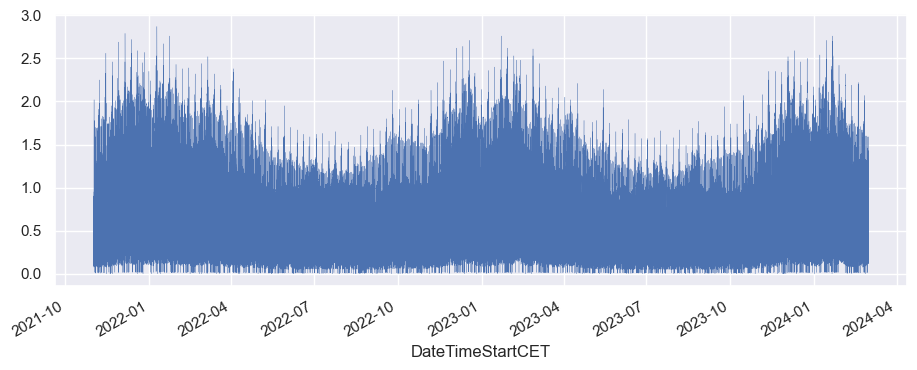

In [5]:
podatki['Odjem ACT'].plot(linewidth=0.2)

<AxesSubplot: xlabel='DateTimeStartCET'>

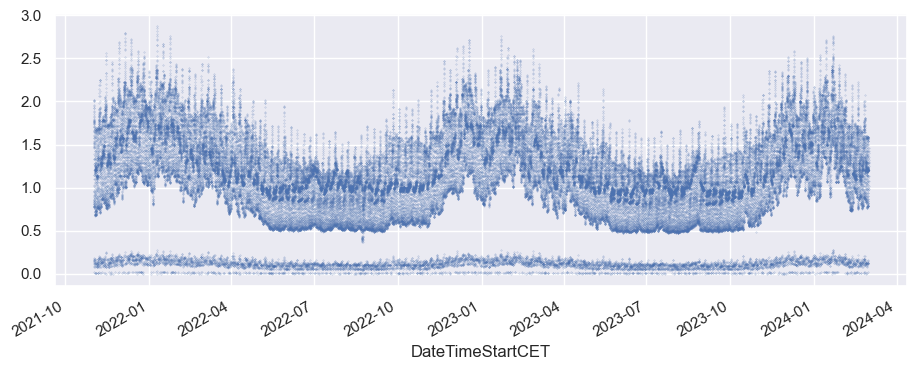

In [25]:
podatki['Odjem ACT'].plot(marker='.', alpha=0.5, linestyle='None', ms=0.5)
# iz tega grafa je malo boljše lažje razbrat stvari

In [49]:
# opazke:
# - poraba je večja v zimskih mesecih
# - poraba se v času božičnih praznikov (konec decembra, začetek januarja) zmanjša
# - tisto kar je blizu nič predstavlja porabo tekom noči

<AxesSubplot: xlabel='DateTimeStartCET'>

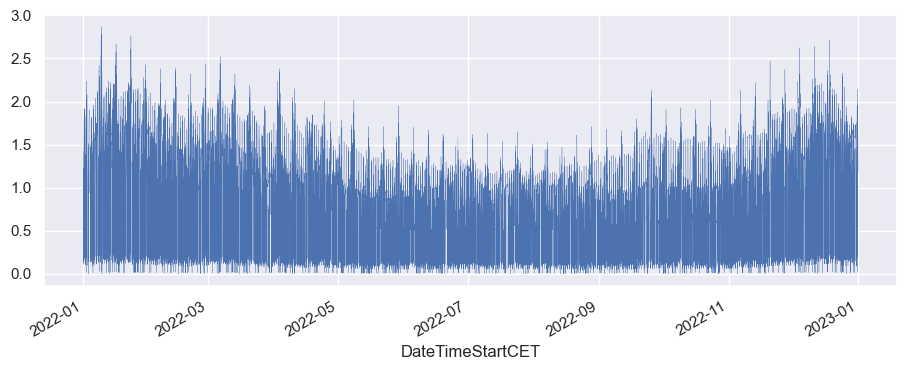

In [56]:
## odjem leta 2022:
podatki.loc['2022', 'Odjem ACT'].plot(linewidth=0.2)

<AxesSubplot: xlabel='DateTimeStartCET'>

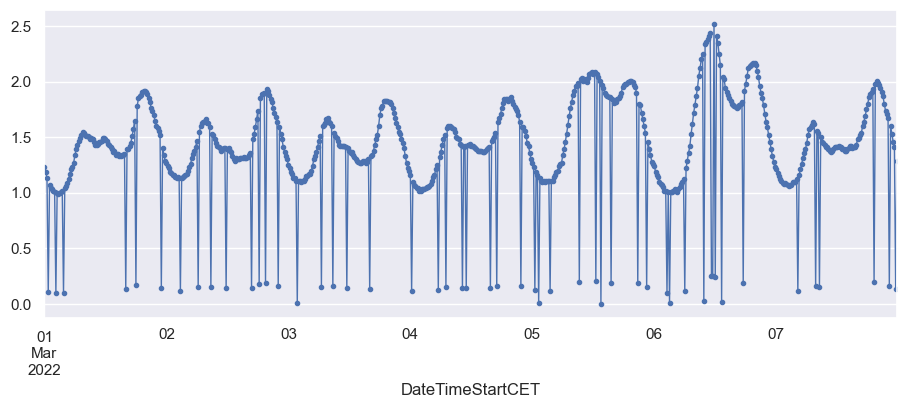

In [26]:
# odjem za en teden
podatki.loc['2022-03-01':'2022-03-07', 'Odjem ACT'].plot(marker='o', linestyle='-', linewidth=1, ms=3)

In [ ]:
# obravnava za napovedovanje

# očitno je, da vrsta NI stacionarna

In [ ]:
# Podatki so volatilni, zato najprej naredimo logaritemsko transformacijo. Tako se vse malo bolj stabilizira 
podatki['Logaritem'] = np.log(podatki['Odjem ACT'])
podatki['Logaritem'].plot(linewidth=0.2)

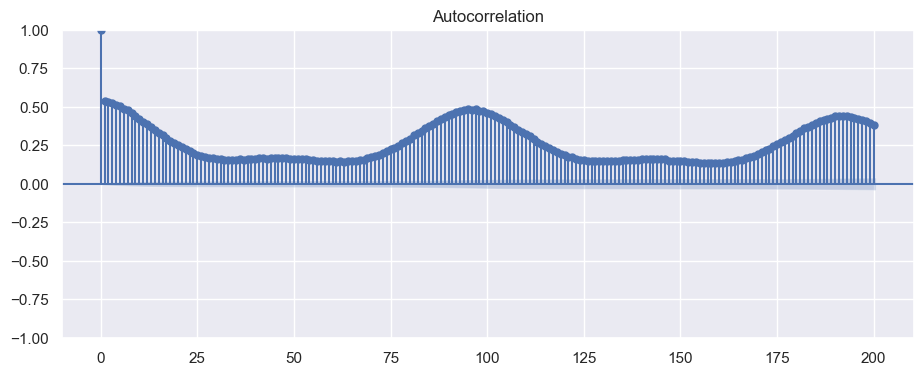

In [50]:
AFT_plot = tsaplots.plot_acf(podatki['Odjem ACT'], lags=200)

In [51]:
# Keep in mind, da so podatki na 15 min !!
# To pomeni, da jih je 96 na dan. 
# Iz ACF vidimo, da imamo sezonstkost, trenda ni, razen če gledaš samo polovico dneva, kar se mi zdi nesmiselno?

# so pa vse konice (spikes) zunaj modrega omočja, kar pomeni, da smo daleč od white noise in korelacija obstaja

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_7124\4014023010.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  podatki_daily_mean = podatki.groupby(['Day']).mean().reset_index()


<AxesSubplot: xlabel='Day'>

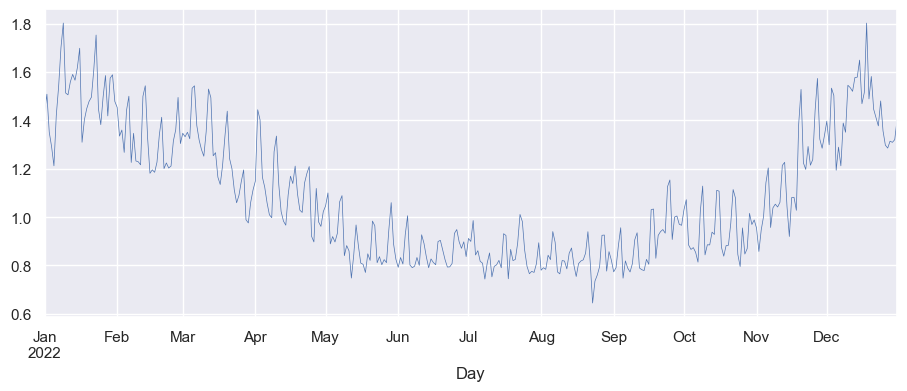

In [70]:
## povprečje po dnevih, da pogledamo bolj na letni ravni sezonskost
podatki_daily_mean = podatki.groupby(['Day']).mean().reset_index()
podatki_daily_mean["Day"] = pd.to_datetime(podatki_daily_mean["Day"], format="%Y-%m-%d")
podatki_daily_mean = podatki_daily_mean.set_index('Day')
podatki_daily_mean

podatki_daily_mean.loc['2022', 'Odjem ACT'].plot(linewidth=0.5)

<AxesSubplot: xlabel='Day'>

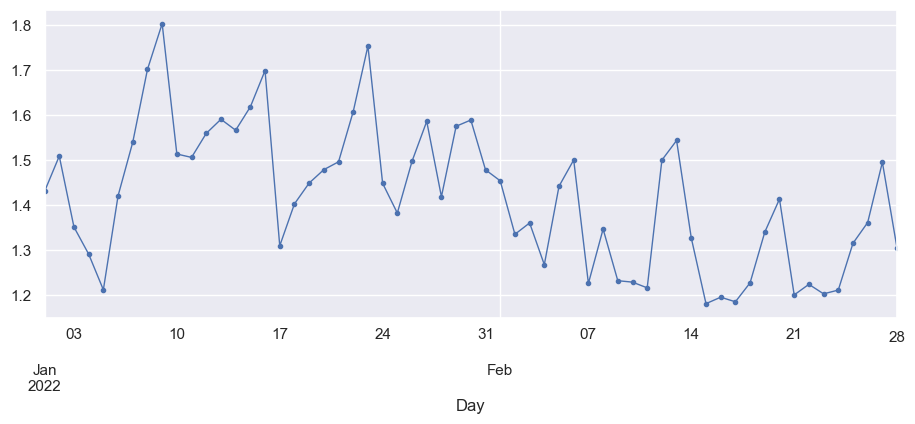

In [80]:
podatki_daily_mean .loc['2022-01':'2022-02', 'Odjem ACT'].plot(marker='o', linestyle='-', linewidth=1, ms=3)

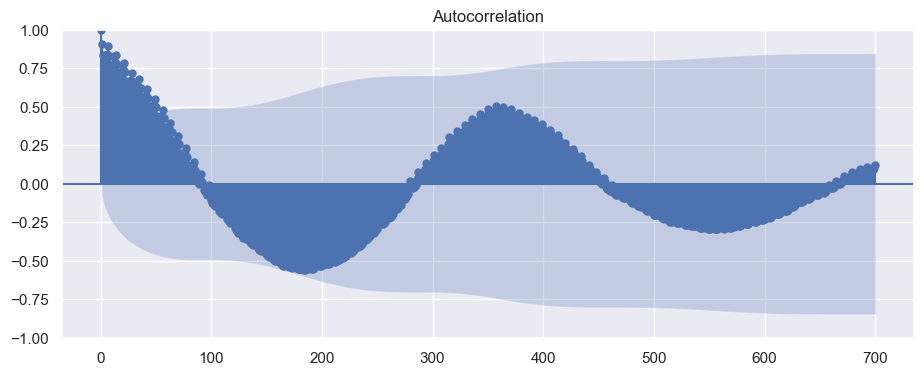

In [53]:
AFT_plot_on_daily_mean = tsaplots.plot_acf(podatki_daily_mean['Odjem ACT'], lags=700)

In [54]:
# Opazna je sezonskost. Perioda je cca. eno leto

In [ ]:
# Znebiti se moramo seozoskosti, še prej pa poglejmo, periodogram, ki nam bo predlagal periodo